# Tides
As a prelude to developing a tide clock I wanted to explore the IoT access to tide data from Ocean.org and [noaa.gov](https://tidesandcurrents.noaa.gov/noaatidepredictions.html?id=8518490) sites

*n.b. some of this work started in CoLab so the code sections may contain the `#@commands` unique to that implementation of Jupyter*

### Libraries

In [1]:
# Non CoLab we want to see the graphs inline (not notebook which makes it interactive)
%matplotlib inline

#@title Basic Libraries
#@markdown data handling and graphics
import pandas as pd
# First the usual imports:
import numpy as np
# matplotlib is the tool that will create the graphs
import matplotlib.pyplot as plt

#@markdown Time libraries
from datetime import tzinfo, timedelta, datetime, date
from pytz import timezone  # should already be part of pandas but it doesn't hurt to do it again.
EST = timezone('America/New_York')

import time
# quick test of 'aware' time
datetime.now(tz=EST).isoformat()

'2022-12-22T11:18:53.072971-05:00'

### Common Elements 

In [2]:
# With each call we flip the units so we toggle back and 
# forth between metric and imperial (we have an international audience)
gTideUnit = 'Tide [ft]' # 'Tide [m]'  # Default units
# values for REST call
measure = ("english", "metric")

stationsNearUs = {  'NewRochelleNY':  "8518490",
                    'RyePlaylandNY':  "8518091",
                    'CosCobCT':       "8469549",
                    'ThrogsNeckBrNY': "8518526",
                    'KingsPointNY':   "8516945",
                    'BatteryNY':      "8518750",
                    'BridgeportCT':   "8467150",
                    'NewHavenCT':     "8465705",
                    "NewboldPA":      "8548989",  # Way up the Chesapeake River
                    'TurkeyPointNY':  "8518962",  # Way up the Hudson River
                    }

tideStation = stationsNearUs['RyePlaylandNY']  # Closest one to us with reliable data
# Visual check at [Mamaroneck Web Cam](https://www.weatherbug.com/weather-camera/?cam=MMBPC) for checking the tides?


## Working Code

### library routines in `tidedata.py`

In [9]:
###
# fetchTideData
# Get raw data from the NOAA tide database/calculator. Tide information is generated based on a harmonic analysis of 
# many years of data. The parameters change every 20 years or so so I could just fetch the numbers but NOAA is cagey
# about how to input the time (what epoch constitutes 0 for example) So I pull the data based on our location.  What
# I do to spare the server is to cache the result so I only pull the data once per day.  This way my 'tide' clock can
# update the current pointer once per 5 minutes without hammering on the server.  This is just the inet fetch part.
#
def fetchTideData(station, begDate, endDate, datum="MLLW", interval=15, timezone="LST_LDT", units="english", clock="24hour"):
  """
  fetchTideData
  Fetch tide from NOAA Site using REST -> pandas DataFrame with tide levels
  required arguments:
    station -- StationID
    begDate -- start date (only fetches using day)
    endDate -- end date

    units -- "english" | "metric" # units
    interval -- "hilo" | "h" | 30 | 15 | 6 | 1 # hi and lo, hourly, min intervals
    datum -- "MLLW" | "STND" | "MHHW" | "MHW" | "MTL" | "MLW" | "MLLW" | "NAVD" # height references
    tzone -- "LST_LDT" | "LST" | "GMT" # Local with dst, local or GMT
    clock -- "24hour" | "12hour" # clock style

    This routine checks a local cache cache so that we don't have to fetch that doesn't change
    that much over a 24 hour period.

  """
  noaaSite = [f"https://tidesandcurrents.noaa.gov/api/datagetter?product=predictions&application=NOS.COOPS.TAC.WL",
              f"&begin_date={begDate.strftime('%Y%m%d')}&end_date={endDate.strftime('%Y%m%d')}",
              f"&datum={datum}",
              f"&station={station}",
              f"&time_zone={timezone}&clock={clock}",
              f"&units={units}&interval={interval}&format=csv",
              ]

  # return "".join(noaaSite)
  tideDF = pd.read_csv("".join(noaaSite))

  # First we need to rename some of the columns to take out extraneous spaces
  repl = dict([(s, s.strip()) for s in tideDF.columns])
  tideDF = tideDF.rename(repl, axis='columns')

  # convert string dates to proper date times and other conveniences for future expansion
  #TODO: Consider only fetching GMT but passing tz object as local timezone
  tideDF['DateTime'] = tideDF['Date Time'].apply(lambda x:datetime.strptime(x, "%Y-%m-%d %H:%M").replace(tzinfo=EST))

  # Provide a column with delta hours for calculations (used mostly for debugging)
  minTime = tideDF['DateTime'].min()
  tideDF['Hours'] = tideDF['DateTime'].apply(lambda x:(x-minTime).total_seconds()/3600)

  # Break out the date and time as a strings for comparison tricks
  tideDF['Date'] = tideDF['Date Time'].apply(lambda x: x[:10])
  tideDF['Time'] = tideDF['Date Time'].apply(lambda x: x[11:])

  # Regardless of which units we fetched generate a column of the other so we don't need to duplicate calls.
  #TODO: Consider only getting metric and provide column of imperial as an option.
  if units=='english':
    # add the other units to the list
    tideDF = tideDF.rename({'Prediction': 'Tide [ft]'}, axis='columns')
    tideDF['Tide [m]'] = tideDF['Tide [ft]'] / 3.28084
    tideDF['Units'] = 'ft Feet'
  else:
    tideDF = tideDF.rename({'Prediction': 'Tide [m]'}, axis='columns')
    tideDF['Tide [ft]'] = tideDF['Tide [m]'] * 3.28084
    tideDF['Units'] = 'm  Meters'

  return tideDF

In [10]:
###
# fetchDailyTides
# The entry point for the getting of regular pieces of information about tides.  This routine checks the local
# store and if it is under 24 hours old uses the local cache. Otherwise it refreshes the cache.
#
def fetchDailyTides(fromTideStation):
    """
    fetchDailyTides
    Fetch daily tide predictions to get the tide data for a few days ahead -> (detailDF, extremaDF)
    This method checks for the existance and timelyness of a local store before going to the web.
    before fethcing from the NOAA site.
    fromTideStation -- NOAA tide station code
    """
    # Local store
    detailTidesFile = 'resources/tmp/DetailTides.zip'  # 15 minute intervals (for smooth graph)
    extremTidesFile = 'resources/tmp/ExtremTides.zip'  # Just the hi and low values for extrema

    # Fetch this data once per day.  And run all the subsequent graphics from the local store.
    now       = datetime.now(tz=EST)
    today     = now.date()

    # Proper way to set up timeshifts.
    yesterday = now - timedelta(days=0)
    tomorrow  = now + timedelta(days=2)

    # First look for existing data, if not found: create, if found: load and test for age
    try:
        print("\t...try to read saved data")
        tideDetailDF = pd.read_pickle(detailTidesFile, compression='infer')
        tideExtremDF = pd.read_pickle(extremTidesFile, compression='infer')
    except FileNotFoundError:
        print("\t...file doesn't exist, creating")
        # Get the data
        tideDetailDF = fetchTideData(fromTideStation, yesterday.date(), tomorrow.date())
        tideDetailDF.to_pickle(detailTidesFile, compression='infer')
        tideExtremDF = fetchTideData(fromTideStation, yesterday.date(), tomorrow.date(), interval='hilo')
        tideExtremDF.to_pickle(extremTidesFile, compression='infer')

    # Check to see if the data is stale (older than one day)...
    if tideDetailDF['DateTime'][1].date()!=today:
        tideDetailDF = fetchTideData(fromTideStation, yesterday.date(), tomorrow.date())
        tideDetailDF.to_pickle(detailTidesFile, compression='infer')

    # Check to see if the data is stale (older than one day)...
    if tideExtremDF['DateTime'][1].date()!=today:
        tideExtremDF = fetchTideData(fromTideStation, yesterday.date(), tomorrow.date(), interval='hilo')
        tideExtremDF.to_pickle(extremTidesFile, compression='infer')

    # The REST Call always returns at least 3 days of infomraiont (can't just return the next 24 hours)
    # so we have to truncate the list.
    selDet = tideDetailDF['DateTime']<tomorrow
    selExt = tideExtremDF['DateTime']<tomorrow

    tideDetailDF = tideDetailDF[selDet]
    tideExtremDF = tideExtremDF[selExt]  
    print(f"\t...start: {tideDetailDF['DateTime'].iloc[0]} end:{tideDetailDF['DateTime'].iloc[-1]}")

    return (tideDetailDF, tideExtremDF)

### Graph Routines in `TidesGraph.py`

In [7]:
###
# makeTideGraph
# The business end that makes the fancy graphic that includes a moing line that shows out current time
# against a graph of the tide height.
#
def makeTideGraph(detailDF, extremaDF):
    """
    makeTideGraph
    Make tide ala NOAA from two sets of pandas DataFrames:
    detailDF -- Detailed predicted water levels for complete graph
    extremeDF -- The extrema (highs and lows)
    """
    global gTideUnit # unit switch flag

    graphFile = "resources/tmp/tideGraph.png"

    import matplotlib.transforms
    import matplotlib.dates as mdates

    today = datetime.now(tz=EST).date()

    # Set up the plot and plot the data
    # px = 1/plt.rcParams['figure.dpi']  # pixel in inches (doesn't work if bbox is 'tight')
    fig, ax = plt.subplots(figsize=(11.5, 4))
    # fig, ax = plt.subplots(figsize=(13, 5))

    ax.plot(detailDF['DateTime'], detailDF[gTideUnit], color="blue", alpha=0.8)

    # Markers at extrema with square marks
    ax.scatter(extremaDF['DateTime'], extremaDF[gTideUnit], color="blue", marker="s")
    for index, row in extremaDF.iterrows():
        xy = (row['DateTime'], row[gTideUnit])
        u = gTideUnit.split("[")[1].split("]")[0]   # row['Units']
        ax.annotate(f'{xy[1]:5.1f} {u[:2]}', xy=xy, xytext=(8,0), textcoords='offset points', color='blue')

    # Set the axis labels
    # ax.set_xlabel("Date and Time", fontsize=14, fontstyle='italic', color='SlateGray')
    ax.set_ylabel(f"Tide Level [{u}]", fontsize=14, fontstyle='italic', color='SlateGray')
    # ~put an alternate axis in meters~ Alternate between meters and feet in 5min intervals

    # Put a vetical bar that marks right now.
    now = datetime.now(tz=EST)
    (ymin, ymax) = ax.get_ylim()
    ax.annotate(f"Current Time   {now.time().strftime('%I:%M %p')}", xy=(now, (ymin+ymax)/2), xytext=(-15,-30), textcoords='offset points', color='green', rotation=90.0, alpha=0.6 )
    ax.vlines(now, ymin=ymin, ymax=ymax, transform=ax.get_xaxis_transform(), colors="green", linewidth=4, alpha=0.7)

    #Fix the time axis
    ax.xaxis.set_major_locator(mdates.DayLocator(tz=EST))
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4, tz=EST))

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%a, %b %d', tz=EST))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M', tz=EST))

    dx = 0.; dy = -10/72.
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    # Create offset transform by 5 points in x direction
    for label in ax.xaxis.get_majorticklabels():
        label.set(horizontalalignment='center', color="darkred", fontweight='bold')
        label.set_transform(label.get_transform() + offset)

    for label in ax.xaxis.get_minorticklabels():
        label.set(horizontalalignment='center', color="darkred")

    ax.grid(True, which='major', linewidth=2, axis='both', alpha=0.7)
    ax.grid(True, which='minor', linestyle="--", axis='both', alpha = 0.5)

    # Display here.
    # fig.show()
    fig.savefig(graphFile, bbox_inches='tight', transparent=True)
    plt.close(fig)

#### Run above

In [ ]:
# Make the tide graph
# Get the data this method tries to fetch from local store first
(ryePlayDetailDF, ryePlayExtremDF) = fetchDailyTides(tideStation)

# make the pseudo NOAA tide graph
makeTideGraph(ryePlayDetailDF, ryePlayExtremDF)

### Graph Routines in `tidesGraphic.py`

In [106]:
#@markdown Make the fancy image with next tide
pathToResources = "resources/"
gTime = '12'
future = 0

def makeTideGraphic(extremaDF, detailDF=None):
    # make up for image import deprecation
    # import PIL
    # import urllib.request
    """
    Make tide ala NOAA from two sets of pandas DataFrames:
    detailDF -- Detailed predicted water levels for complete graph
    extremeDF -- The extrema (highs and lows)
    """
    global gTime

    lbl = {'H': 'HIGH', 'L': 'LOW'}

    # imageURL = 'https://docs.google.com/drawings/d/e/2PACX-1vRPpyCKk834LQUUwoEWDiopLKIcRscn3AoUPynXzNe6jPRLXWt9TBS90Wwm_MjxVoqezD09hbx_0Sw8/pub?w=225&h=159'
    # imageRef = PIL.Image.open(urllib.request.urlopen(imageURL))
    imageRef = pathToResources + 'TideBackground.png' # fetch locally (way faster on a pi)
    imageOverlay = plt.imread(imageRef)
    (hgt,wdt,cols) = imageOverlay.shape

    plt.figure(figsize=(3, 3))

    implot = plt.imshow(imageOverlay)
    implot.axes.get_xaxis().set_visible(False)
    implot.axes.get_yaxis().set_visible(False)

    upcoming = extremaDF[extremaDF['DateTime']>datetime.now(tz=EST)]
    nxtTide = upcoming.iloc[0]

    if gTime == '24':
        plt.text(wdt/2, 40, nxtTide['DateTime'].strftime('%H:%M'), fontsize=26.0, ha='center' )
    else:
        plt.text(wdt/2, 40, nxtTide['DateTime'].strftime('%I:%M %p'), fontsize=26.0, ha='center' )
    plt.text(wdt/2, 80, lbl[nxtTide['Type']], fontweight='heavy', color='blue', fontsize=20.0, ha='center')

    if nxtTide['Type'] == 'H':
        len = -50
    else:
        len = 50
    plt.arrow(wdt/6, 65-len/4, 0, len, width=6., color='cyan',
                length_includes_head=True, alpha=0.6, fill=False, linewidth=2.0)

    # Somehwat kludgy since we know the range is between -1 and 10ft
    try:
        current = detailDF[detailDF['DateTime']>datetime.now(tz=EST)]
        nxtTide = current.iloc[future]
    finally:
        level = nxtTide['Tide [ft]']  # don't care since all we do is scale

    # arbitrary scaling so we fit tides in our area range from -1ft to +10ft
    sclDepth = (level + 1.5) / 12.0
    scaledTideHeight = int(hgt*sclDepth)

    print(f"time: {current.iloc[future]['DateTime'].strftime('%I:%M %p')}, hgt: {hgt}, level: {level:6.2f}, scaleDepth: {sclDepth:6.3f}, scaledHeight: {scaledTideHeight:6d}")

    plt.title('Next Tide At...')
    plt.axis('off')
    t = np.linspace(0, wdt, 50)
    y = (hgt-20) - (scaledTideHeight + 2 * np.cos(t/4)**2)

    plt.fill_between(t, hgt-20, y, color='SkyBlue', alpha=0.50)

    plt.show()
    #plt.savefig(pathToResources  + 'tmp/' + 'tideCartoon.png', bbox_inches='tight', transparent=True)
    plt.close()


#### Run Above

In [86]:
print(f"Tides - min: {ryePlayDetailDF['Tide [ft]'].min()} - max: {ryePlayDetailDF['Tide [ft]'].max()}")

Tides - min: -1.14 - max: 8.969


time: 12:26 PM, hgt: 125, lvl: 121, level:   5.51, scaleDepth:  0.584, scaledHeight:     73


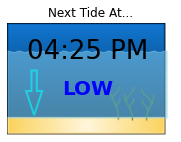

time: 12:41 PM, hgt: 125, lvl: 121, level:   4.93, scaleDepth:  0.536, scaledHeight:     67


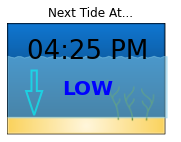

time: 12:56 PM, hgt: 125, lvl: 121, level:   4.33, scaleDepth:  0.486, scaledHeight:     60


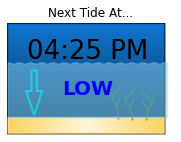

time: 01:11 PM, hgt: 125, lvl: 121, level:   3.71, scaleDepth:  0.434, scaledHeight:     54


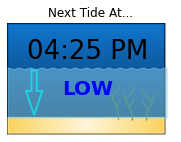

time: 01:26 PM, hgt: 125, lvl: 121, level:   3.09, scaleDepth:  0.382, scaledHeight:     47


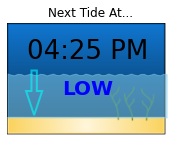

time: 01:41 PM, hgt: 125, lvl: 121, level:   2.48, scaleDepth:  0.332, scaledHeight:     41


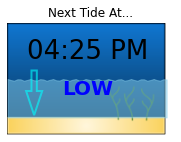

time: 01:56 PM, hgt: 125, lvl: 121, level:   1.89, scaleDepth:  0.283, scaledHeight:     35


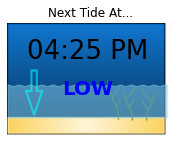

time: 02:11 PM, hgt: 125, lvl: 121, level:   1.34, scaleDepth:  0.237, scaledHeight:     29


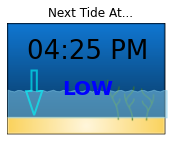

time: 02:26 PM, hgt: 125, lvl: 121, level:   0.84, scaleDepth:  0.195, scaledHeight:     24


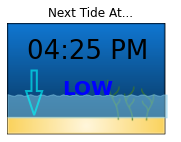

time: 02:41 PM, hgt: 125, lvl: 121, level:   0.39, scaleDepth:  0.158, scaledHeight:     19


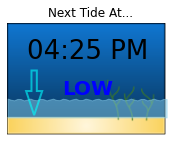

time: 02:56 PM, hgt: 125, lvl: 121, level:   0.01, scaleDepth:  0.126, scaledHeight:     15


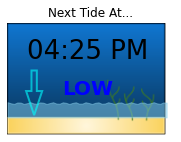

time: 03:11 PM, hgt: 125, lvl: 121, level:  -0.32, scaleDepth:  0.099, scaledHeight:     12


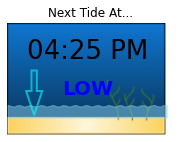

time: 03:26 PM, hgt: 125, lvl: 121, level:  -0.58, scaleDepth:  0.077, scaledHeight:      9


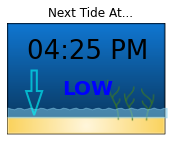

time: 03:41 PM, hgt: 125, lvl: 121, level:  -0.77, scaleDepth:  0.061, scaledHeight:      7


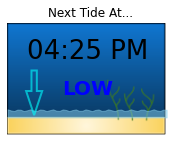

time: 03:56 PM, hgt: 125, lvl: 121, level:  -0.91, scaleDepth:  0.049, scaledHeight:      6


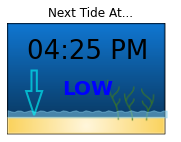

time: 04:11 PM, hgt: 125, lvl: 121, level:  -0.99, scaleDepth:  0.042, scaledHeight:      5


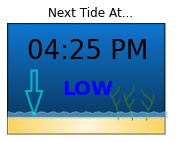

time: 04:26 PM, hgt: 125, lvl: 121, level:  -1.01, scaleDepth:  0.040, scaledHeight:      5


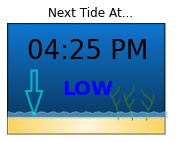

time: 04:41 PM, hgt: 125, lvl: 121, level:  -0.98, scaleDepth:  0.043, scaledHeight:      5


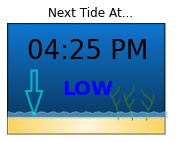

time: 04:56 PM, hgt: 125, lvl: 121, level:  -0.90, scaleDepth:  0.050, scaledHeight:      6


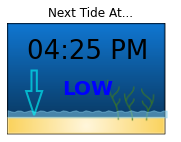

time: 05:11 PM, hgt: 125, lvl: 121, level:  -0.76, scaleDepth:  0.062, scaledHeight:      7


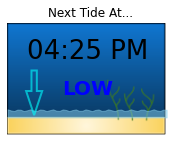

time: 05:26 PM, hgt: 125, lvl: 121, level:  -0.55, scaleDepth:  0.079, scaledHeight:      9


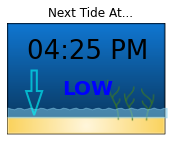

time: 05:41 PM, hgt: 125, lvl: 121, level:  -0.28, scaleDepth:  0.102, scaledHeight:     12


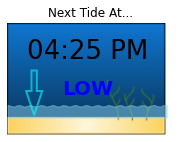

time: 05:56 PM, hgt: 125, lvl: 121, level:   0.06, scaleDepth:  0.130, scaledHeight:     16


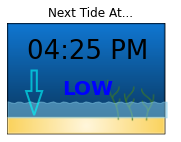

time: 06:11 PM, hgt: 125, lvl: 121, level:   0.47, scaleDepth:  0.164, scaledHeight:     20


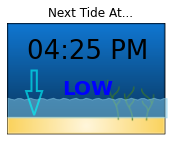

time: 06:26 PM, hgt: 125, lvl: 121, level:   0.94, scaleDepth:  0.204, scaledHeight:     25


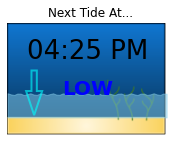

time: 06:41 PM, hgt: 125, lvl: 121, level:   1.49, scaleDepth:  0.249, scaledHeight:     31


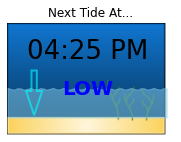

time: 06:56 PM, hgt: 125, lvl: 121, level:   2.08, scaleDepth:  0.298, scaledHeight:     37


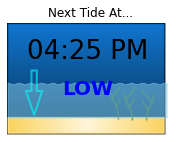

time: 07:11 PM, hgt: 125, lvl: 121, level:   2.71, scaleDepth:  0.351, scaledHeight:     43


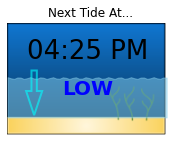

time: 07:26 PM, hgt: 125, lvl: 121, level:   3.37, scaleDepth:  0.406, scaledHeight:     50


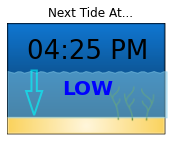

time: 07:41 PM, hgt: 125, lvl: 121, level:   4.04, scaleDepth:  0.461, scaledHeight:     57


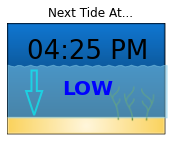

time: 07:56 PM, hgt: 125, lvl: 121, level:   4.68, scaleDepth:  0.515, scaledHeight:     64


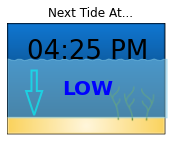

time: 08:11 PM, hgt: 125, lvl: 121, level:   5.29, scaleDepth:  0.566, scaledHeight:     70


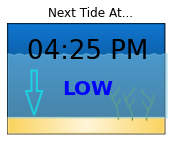

time: 08:26 PM, hgt: 125, lvl: 121, level:   5.85, scaleDepth:  0.613, scaledHeight:     76


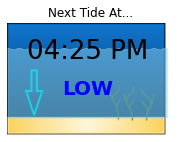

time: 08:41 PM, hgt: 125, lvl: 121, level:   6.34, scaleDepth:  0.654, scaledHeight:     81


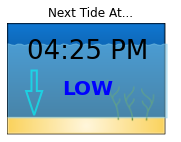

time: 08:56 PM, hgt: 125, lvl: 121, level:   6.76, scaleDepth:  0.688, scaledHeight:     86


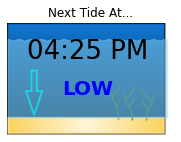

time: 09:11 PM, hgt: 125, lvl: 121, level:   7.09, scaleDepth:  0.716, scaledHeight:     89


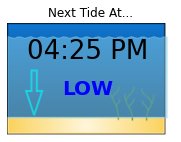

time: 09:26 PM, hgt: 125, lvl: 121, level:   7.34, scaleDepth:  0.737, scaledHeight:     92


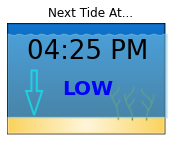

time: 09:41 PM, hgt: 125, lvl: 121, level:   7.51, scaleDepth:  0.751, scaledHeight:     93


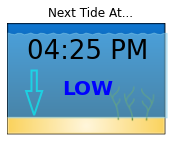

time: 09:56 PM, hgt: 125, lvl: 121, level:   7.62, scaleDepth:  0.760, scaledHeight:     94


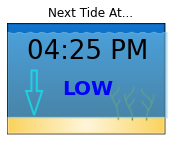

time: 10:11 PM, hgt: 125, lvl: 121, level:   7.65, scaleDepth:  0.763, scaledHeight:     95


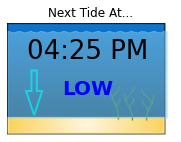

In [107]:
# Get the data this method tries to fetch from local store first
#(ryePlayDetailDF, ryePlayExtremDF) = fetchDailyTides(tideStation)  # run this once for each cartoon
gTime = '12'
futureStart = 0
# make the pseudo 'next tide' graphic
for i in range(40):
    future = futureStart + i
    makeTideGraphic(ryePlayExtremDF, ryePlayDetailDF)

### Generation Routine in `TidesTable.py`

In [9]:
#@markdown Make the summary table for the next four tide extrema 
def makeTideTable(extremaDF):
    """
    Make the html table of the next 4 tide extrema
    extremeDF -- The extrema (highs and lows)
    """
    global gTideUnit
    lbl = {'H': 'HIGH', 'L': 'LOW'}

    now = datetime.now(tz=EST)

    tideFile = "tideTable.html"
    templateFile = "_" + tideFile

    # pick the units based on gTideUnit

    sel = extremaDF['DateTime'] > now
    futureTides = extremaDF[sel]

    htmlText = futureTides[:4].to_html( 
#                            columns=['DateTime', 'Time', 'Type', gTideUnit], 
                            columns=['DateTime', 'Type', gTideUnit], 
                            index=False, 
                            border=0,
                            formatters={
                                gTideUnit: lambda x:f"{x:6.1f}",
                                'Type': lambda l: lbl[l],
                                'DateTime': lambda dt: dt.strftime("%a %I:%M %p")
                                },
#                            table_id = "tideTable"
                            )

    #open the template file
    with open(templateFile, "r") as templateFile:
        templateHTML = templateFile.readlines()
 
    # print( ("".join(templateHTML)).replace('<!--Table Place-->', htmlText) )
    # print( htmlText )
    
    # copy the html table into the text and write out a new file 
    with open(tideFile, "w") as htmlFile:
        htmlFile.write( ("".join(templateHTML)).replace('<!--Table Place-->', htmlText) )


#### Run Above

In [10]:
# Get the data this method tries to fetch from local store first
(ryePlayDetailDF, ryePlayExtremDF) = fetchDailyTides(tideStation)

# make the pseudo NOAA tide graph
makeTideTable(ryePlayExtremDF)

	...try to read saved data
	...start: 2022-01-28 23:56:00-05:00 end:2022-01-31 13:41:00-05:00


### Generation Routine in `WindGraph.py`

In [12]:
EST = timezone('America/New_York')
UTC = timezone('UTC')

import matplotlib.transforms
import matplotlib.dates as mdates

# Getting Weather Data from execution rocks (station 44022)  Only needs to run every 15 minutes.
def fetchWindData(source):
  now = datetime.now(tz=EST)

  windDF = pd.read_csv(source, delim_whitespace=True, header=[0,1], na_values='MM', nrows=450 )
  print(f"\t...got {len(windDF)} data values")

  windDF['DateTime'] = windDF[['#YY','MM','DD','hh','mm']].apply(lambda dt: datetime(dt[0], dt[1], dt[2], dt[3], dt[4], tzinfo=UTC).astimezone(EST), axis=1)
  windDF['Time'] = windDF['DateTime'].apply(lambda t: t.time())
  windDF['Date'] = windDF['DateTime'].apply(lambda d: d.date())
  windDF['Wdir'] = windDF['WDIR'] + 360.0  # done so averaging over modulo 360.0 works properly

  return windDF #.set_index(windDF['DateTime'] - windDF['DateTime'].min()) # returns a new copy
#  return windDF.set_index('DateTime')

def makeWindGraph(windDF, whereFrom=""):
  imageRef = "resources/tmp/windGraph.png" # fetch locally (way faster on a pi)
  fig, ax = plt.subplots(figsize=(8, 4))

  tme = windDF.index
  wspd = windDF['WSPD'] # windDF['WSPD']
  mxsp = windDF['GST'] # windDF['GST']

  # convert m/s to mph: 0.447, m/s to knot: 0.5144
  ax.plot(tme, wspd/0.5144, 'bo-', alpha=0.8)
  ax.plot(tme, mxsp/0.5144, 'ro-', alpha=0.8)

  # Plot direction arrows
  # convert from compass to theta (use coordinate swap to do the rotation) 
  angl = np.radians(windDF['Wdir'])
  yloc = 3.0 * np.ones_like(angl)
  # why would we add 360??? because the average between 10 and 350 is 180 
  #       when the correct answer w.r.t. wind direction is 0.0 mod(360.0) 
  # An arrow every other step
  ax.quiver(tme[::2], yloc[::2], np.sin(angl[::2]), np.cos(angl[::2]), 
            angles='uv', color='DodgerBlue', alpha=0.6, pivot='middle')

  # Set the axis labels
  # ax.set_xlabel("Date and Time", fontsize=10, fontstyle='italic', color='SlateGray')  #obvious don't need it.
  ax.set_ylabel("Wind Speed [knots]", fontsize=12, fontstyle='italic', color='SlateGray')

  #Fix the time axis
  ax.xaxis.set_major_locator(mdates.DayLocator(tz=EST))
  ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4, tz=EST))

  ax.xaxis.set_major_formatter(mdates.DateFormatter('%a, %b %d', tz=EST))
  ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M', tz=EST))

  dx = 0.; dy = -10/72.
  offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
  # Create offset transform by 5 points in x direction
  for label in ax.xaxis.get_majorticklabels():
      label.set(horizontalalignment='center', color="darkred", fontweight='bold')
      label.set_transform(label.get_transform() + offset)

  for label in ax.xaxis.get_minorticklabels():
      label.set(horizontalalignment='center', color="darkred")

  ax.grid(True, which='major', linewidth=2, axis='both', alpha=0.7)
  ax.grid(True, which='minor', linestyle="--", axis='both', alpha = 0.5)
  ax.set_ylim(bottom=0.0)

  # where did this come from?
  plt.text(0.99, 0.96, f"{whereFrom}", 
        horizontalalignment='right', verticalalignment='center', 
        transform=ax.transAxes, color='gray', alpha=0.6 )

  # fig.show()
  fig.savefig(imageRef, bbox_inches='tight', transparent=True)
  plt.close(fig)

# Exscution Rocks weather buoy
real_EXR_TimeDataFile = "https://www.ndbc.noaa.gov/data/realtime2/44022.txt"
# Kings Point
real_KPH_TimeDataFile = "https://www.ndbc.noaa.gov/data/realtime2/KPTN6.txt"
# Western Long Island Sound
real_WLI_TimeDataFile = "https://www.ndbc.noaa.gov/data/realtime2/44040.txt"



#### Run Above

In [13]:
now = datetime.now().astimezone(EST)
d = timedelta(days = 2)

# try to get execution rocks first, then WestLI, falling back to nearest manned land station
try:
    source = "Execution Rocks"
    print(f"\t...source: {source}")
    theDF = fetchWindData(real_EXR_TimeDataFile)
    smpl = theDF['DateTime'] > (now - d)
    makeWindGraph( theDF[smpl].resample('1H', on='DateTime').mean(), source )
except:
    print("\t... failed")
    # if that fails then try western LI buoy
    try:
        source = "Western LI"
        print(f"\t...source: {source}")
        theDF = fetchWindData(real_WLI_TimeDataFile)
        smpl = theDF['DateTime'] > (now - d)
        makeWindGraph( theDF[smpl].resample('1H', on='DateTime').mean(), source )
    except:
        print("\t... failed")
        # if that fails then settle on Kings Point (never fails)
        source = "Kings Point LI"
        print(f"\t...source: {source}")
        theDF = fetchWindData(real_KPH_TimeDataFile)
        smpl = theDF['DateTime'] > (now - d)
        makeWindGraph( theDF[smpl].resample('1H', on='DateTime').mean(), source )


	...source: Execution Rocks
	...got 450 data values


### Generation Routine in `Forecast.py`

A few notes about this kludge. NOAA is slowly rolling out an efficient REST system for local forecasts. They have yet to implement the marine forecasts. What we do have are web pages that are nicely laid out that can be harvested for the details we need. Each sector provides a set of forecasts for customized regions within.  We can pick the one we want and extract the daily predictions from there.  These short messages are all we want or need. Further I only need a few days out (about 6 panels.)

In [14]:
import numpy as np
from html.parser import HTMLParser


"""
MarineHTMLParser
    custom extension of HTMLParser to extract informaion from 
    NOAA/NWS Marine Forecasts
"""
class MarineHTMLParser(HTMLParser):
  """
    custom class to parse the marine weather forecast for our area
  """
  # an array of dictionaries
  forecasts = []

  def __init__(self):
    """
      init the parser elements
    """
    super(MarineHTMLParser, self).__init__()
    self.inPreString = False
    self.forecast = dict()

  def handle_starttag(self, tag, attrs):
    """
      handle any starting html tag, we are only looking for the <pre> tags
      we initialize the forecast dictionary and the data counter index
    """
    if tag.lower() == "pre":
      self.inPreString = True
      self.forecast = dict()
      self.count = 0

  def handle_endtag(self, tag):
    """
      handle the closing </pre> tag and add the dict to the array
    """
    if tag.lower() == "pre":
      if self.inPreString:  # obviously
        self.forecasts.append(self.forecast)
        self.inPreString = False

  def handle_data(self, data):
    """
      this is the business end, there are a series of data elements
      (I play the cards I'm dealt) the first is a REGION while the second
      is a SYNOPSIS slug, the third is the OVERVIEW. Subsequent data 
      pieces are a sequence of TIME and ADVISORY sequences which seem to
      number around 11.
    """
    if self.inPreString:
      if self.count == 0:
        self.forecast['REGION'] = data.strip()
      elif self.count > 0 and self.count % 2 == 1:
        idx = f"TIME{int((self.count+1)/2):02d}"
        self.forecast[idx] = data.strip()
      else:
        idx = f"ADVISORY{int((self.count)/2):02d}"
        self.forecast[idx] = data.strip().replace('\n',' ')
      self.count += 1


#### Run Above

In [15]:
"""
We want to run this command peridoically to update the clock. I run it within python 
we run the risk of memory leaks so I will run it as a periodic bash shell (we only 
have to run once every 2hrs or so)
"""
forecastFile = "forecastGrid.html"
templateFile = "_" + forecastFile

# url of marine forecast in our area
url = "https://www.ndbc.noaa.gov/data/Forecasts/FZUS51.KOKX.html"

# creating HTTP response object from given url
parser = MarineHTMLParser()

import urllib.request
with urllib.request.urlopen(url) as resp:
    parser.feed(resp.read().decode("utf-8"))

"""
The first record is special, it contains general information about the region
"""
# print(parser.forecasts[0]['REGION']) # Off. designation for covered area
# print('-')
# print(parser.forecasts[0]['TIME01']) # Short version of location
# print('-')
# print(parser.forecasts[0]['ADVISORY01']) # Reason for following forecasts
# print('-----------')
# print()

"""
The subsequent records follow the pattern of REGION and a sequence of 
Times and Advisories
"""
#    for j in range(len(parser.forecasts)):

designation = (parser.forecasts[6]['REGION']).replace('\n',' ').split('- ')
try:
    specialWarning = designation[2].split("...")[1]
    designation[2] = designation[2].split("...")[0]
except:
    specialWarning = ""

        # Off. designation for covered area
titleArea = f'''
    <p class="where">{designation[1]}</p>
    <p class="when">{designation[2]}</p>
    '''
forecastBox = []
for i in range(np.min([6, len(parser.forecasts)-1]) ):
    # print(parser.forecasts[6][f"TIME{i+1:02d}"]) # Short version of location
    # print('==')
    tmeidx = f"TIME{i+1:02d}"
    advidx = f"ADVISORY{i+1:02d}"
    forecastBox.append(f'''
            <p class="what">{parser.forecasts[6][tmeidx]}</h3>
            <p  class="how">{parser.forecasts[6][advidx]}</p>
        ''')

#open and read the template file
with open(templateFile, "r") as templateFile:
    templateData = templateFile.readlines()

# Title Information
templateData = ("".join(templateData)).replace('<!--Forecast Title-->', titleArea)
# Forecast Boxes
for i in range(len(forecastBox)):
    templateData = templateData.replace(f'<!--Forecast Box_{i}-->', forecastBox[i])

templateData = templateData.replace('<!--Special Warning-->', specialWarning)


# copy the html table into the text and write out a new file 
with open(forecastFile, "w") as htmlFile:
    htmlFile.write( templateData )

---
# Tide Experimental Section
Below here are the experiments that led to the above routines.

## REST Method for Tide Data

Tide data can be fetched via a REST call outlined below.  This is the testing area for the development of the fetchTideData method listed above.

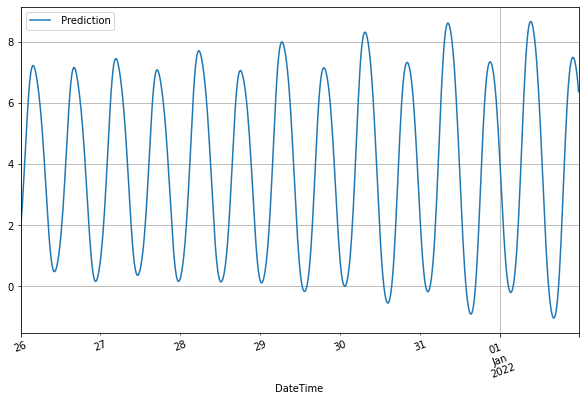

In [24]:
#@ title REST Parameters
startD = date(2021, 12, 26)  # GMT time so that
endD = date(2022, 1, 1)

startDate = startD.strftime("%Y%m%d")
endDate = endD.strftime("%Y%m%d")
stations = {'NewRochelleNY':  "8518490",
            'RyePlaylandNY':  "8518091",
            'CosCobCT':       "8469549",
            'ThrogsNeckBrNY': "8518526",
            'KingsPointNY':   "8516945",
            'BatteryNY':      "8518750",
            'BridgeportCT':   "8467150",
            'NewHavenCT':     "8465705",
            "NewboldPA":      "8548989",
            'TurkeyPointNY':  "8518962",
            }

station = stations['RyePlaylandNY']
units = "english" # "metric"
# interval = "hilo"  # hi and lo tides
# interval = "h"     # hourly 
interval = "15"      # 30,15,6,1 min
datum = "MLLW" # "STND" "MHHW" "MHW" "MTL" "MLW" "MLLW" "NAVD"
timezone = "LST_LDT" # "LST" or "GMT"
clock = "24hour" # "12hour"

noaaSite = f"https://tidesandcurrents.noaa.gov/api/datagetter?product=predictions&application=NOS.COOPS.TAC.WL&begin_date={startDate}&end_date={endDate}&datum={datum}&station={station}&time_zone={timezone}&clock={clock}&units={units}&interval={interval}&format=csv"

tideDF = pd.read_csv(noaaSite)
try:
  # convert string dates to proper date times
  tideDF['DateTime'] = tideDF['Date Time'].apply(lambda x:datetime.strptime(x, "%Y-%m-%d %H:%M"))
  minTime = tideDF['DateTime'].min()
  tideDF['hours'] = tideDF['DateTime'].apply(lambda x:(x-minTime).total_seconds()/3600)
  tideDF.plot('DateTime', ' Prediction', figsize=(10, 6), rot=20, grid=True)
except:
  print(tideDF)


In [25]:
#@title Make graphical simulation of NOAA chart
def makeTideGraph(detailDF, extremaDF):
    """
    Make tide ala NOAA from two sets of pandas DataFrames:
    detailDF -- Detailed predicted water levels for complete graph
    extremeDF -- The extrema (highs and lows)
    """
    global gTideUnit # unit switch flag

    graphFile = "resources/tmp/TideGraph.png"

    import matplotlib.transforms
    import matplotlib.dates as mdates

    today = datetime.now(tz=EST).date()

    # Set up the plot and plot the data
    # px = 1/plt.rcParams['figure.dpi']  # pixel in inches (doesn't work if bbox is 'tight')
    fig, ax = plt.subplots(figsize=(12, 4))

    ax.plot(detailDF['DateTime'], detailDF[gTideUnit], color="blue", alpha=0.8)

    # Markers at extrema with square marks
    ax.scatter(extremaDF['DateTime'], extremaDF[gTideUnit], color="blue", marker="s")
    for index, row in extremaDF.iterrows():
        xy = (row['DateTime'], row[gTideUnit])
        u = gTideUnit.split("[")[1].split("]")[0]   # row['Units']
        ax.annotate(f'{xy[1]:5.2f} {u[:2]}', xy=xy, xytext=(8,0), textcoords='offset points', color='blue')

    # Set the axis labels
    # ax.set_xlabel("Date and Time", fontsize=14, fontstyle='italic', color='SlateGray')
    ax.set_ylabel(f"Tide Level in {u}", fontsize=14, fontstyle='italic', color='SlateGray')
    # ~put an alternate axis in meters~ Alternate between meters and feet in 5min intervals

    # Put a vetical bar that marks right now.
    now = datetime.now(tz=EST)
    (ymin, ymax) = ax.get_ylim()
    ax.annotate(f"Current Time   {now.time().strftime('%I:%M %p')}", xy=(now, (ymin+ymax)/2), xytext=(-15,-30), textcoords='offset points', color='green', rotation=90.0, alpha=0.6 )
    ax.vlines(now, ymin=ymin, ymax=ymax, transform=ax.get_xaxis_transform(), colors="green", linewidth=4, alpha=0.7)

    #Fix the time axis
    ax.xaxis.set_major_locator(mdates.DayLocator(tz=EST))
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4, tz=EST))

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d', tz=EST))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M', tz=EST))

    dx = 0.; dy = -10/72.
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    # Create offset transform by 5 points in x direction
    for label in ax.xaxis.get_majorticklabels():
        label.set(horizontalalignment='center', color="darkred", fontweight='bold')
        label.set_transform(label.get_transform() + offset)

    for label in ax.xaxis.get_minorticklabels():
        label.set(horizontalalignment='center', color="darkred")

    ax.grid(True, which='major', linewidth=2, axis='both', alpha=0.7)
    ax.grid(True, which='minor', linestyle="--", axis='both', alpha = 0.5)

    fig.show()
    #fig.savefig(graphFile, bbox_inches='tight', transparent=True)
    plt.close(fig)


### Run the Graph

### Cross correlations

In [ ]:
startD = date(2021, 12, 25)
endD = date(2021, 12, 30)

ryeDF = fetchTideData(stations['RyePlaylandNY'], startD, endD) 
otherDF = fetchTideData(stations['TurkeyPointNY'], startD, endD)

plt.plot(ryeDF['Hours'],ryeDF['Prediction'], color="blue", alpha=0.8)
plt.plot(otherDF['Hours'], otherDF['Prediction'], color="red", alpha=0.8)
plt.show()

You would expect to see some phase shift of tides as you move to the east or west.  (Or up an estuary)

### Harmonic Constants for a given station

With a station number we can get the parameters that predict the tide for a given location given the following parameters from NOAA.

 - Constituent #
 > Order in which the National Ocean Service lists the constituents
 - Name
 > Common name used to refer to a particular constituent, subscript refers to the number of cycles per day
 - Amplitude $A_i$
One-half the range of a tidal constituent. (*In other words the standard definition of amplitude*)
 - Phase $\Phi_i$ (*the phase of this component relative to the others*)
 > The phase lag of the observed tidal constituent relative to the theoretical equilibrium tide. = $\frac{180}{\pi}\phi$
 - Speed $\Omega_i$ (*the angular speed, a.k.a. angular frequency associated with this component*)
 > The rate change in the phase of a constituent, expressed in degrees per hour. The speed is equal to 360 degrees divided by the constituent period expressed in hours. = $\frac{180}{\pi}\;3600\;\omega$ where $\omega$ is in $rad/s$
 - Description
 > The full name of the tidal constituent

Amplitudes are in feet. Phases are in degrees, referenced to Local. Z0 (MSL): 0 feet.

The basic model would be cast as...
$$\sum_{i=1}^{32} A_i \cos(\phi_i + \omega_i t)$$

or

```python
phi   = np.pi/180. * Phase
omega = np.pi/180 * Speed / 3600.
amp   = Amplitude
```

The piece that is missing here is exactly from when do we measure the highest tide to start the calculation. From reading various reports and documents I gather that this time shift factor is reset every few years to make sure the calculation matches up with the measurements (NOAA is always checking against actual readings.)



In [ ]:
#@title Harmonic Constants for Rye Playland Beach
site = "https://tidesandcurrents.noaa.gov/harcon.html?id=" + stations['RyePlaylandNY']

constDF = pd.read_html(site, header=0)[0]
constDF['phi'] = constDF['Phase'] * np.pi / 180.0
constDF['omega'] = constDF['Speed'] * np.pi / 180.0 / 3600.0

coefs = constDF[['Amplitude','phi','omega']].to_numpy()

In [ ]:
#@markdown `tide` calculates the amplitude based on the parameters
def tide(terms, time):
  tideLevel = 0.0
  for [amp,phi,omega] in terms:
    tideLevel += amp * np.cos(omega * time + phi)
    # for point of reference this takes about 50 lines of Fortran Code
  return tideLevel

# initialize the arrays
hours = np.array([])
hgt = np.array([])

# this ought to be 'vectorizable' but I can't seem to get it to work.
for h in range(3*24): # a week
  hours = np.append(hours, h)
  hgt = np.append(hgt, tide(coefs, h*3600))

plt.plot(hours,hgt)

plt.show()

Superimpose the harmonic estimation with the data passed from a REST call to the NOAA site.

In [ ]:
startD = datetime(2021, 12, 20, 2, 0, tzinfo=EDT)
endD = datetime(2021, 12, 30, 2, 0, tzinfo=EDT)

tideDF = fetchTideData(stations['RyePlaylandNY'], startD, endD) 

d1 = tideDF['DateTime'].min() #datetime(2021, 12, 28, 0, 0, 0, tzinfo=EDT)
d2 = tideDF['DateTime'].max() #datetime(2021, 12, 30, 8, 0, 0, tzinfo=EDT)

hgt = np.array([])

intrv = np.linspace(d1.toordinal()*24, 24+d2.toordinal()*24, num=300, endpoint=True)
shift = 12.2  # time phase shift
for i in intrv:
  hgt = np.append(hgt, tide(coefs, (i-shift)*3600))


plt.figure(figsize=(20,6))
# Plot the harmonic values
plt.plot((intrv-intrv.min()), hgt+3.5)
plt.xticks([i for i in range(0,260,12)])


restHours = tideDF['Hours'].to_numpy()
restAmp = tideDF['Prediction'].to_numpy()

plt.scatter(restHours, restAmp, alpha=0.6)
plt.grid(True)
plt.show()


## Tide Clock Design Notes

So how to make an easily seen display of the tide situation. I have in my hardware kits:
  - Nested NeoPixel Wheels, a stack of 1+8+12+16+24+32 or 61 pixels in total
  - individual neopixels galore
  - Mechanical indicators are not out of the question.
  - How about a discarded 720p display in a case run by a Raspberry Pi?



### Round 1

Use an old Dell Screen which was to be decommisioned.
  - Program a **Raspberry Pi B v1.1** to drive the screen
      - Design and layout the graphics
      - Power the ℿ from the 12V audio connection (*Buck converter*)
  - Build a 'weather resistant' case from wood and plexi.
  - Design a mount for placing where the clock was.

Need to consider things to put on the screen (plenty-o real estate)
  - The graph of the next 48 hours (format the way NOAA does it)
  - The time of the next tide extrema (high or low)
  - Moon phase?
  - subtle clues as to when the last access of NOAA data was.
  - Grab data from NOAA in a responsible way (once every 24 hours?)
  - Today's Date (of course)
  - Weather data?

References:
 - [Rye Playland, Harmonic Calculations](https://tidesandcurrents.noaa.gov/noaatidepredictions.html?id=8518091)  Harmonic estimates checked against measurements.
 - [Larchmont Harbor, NY](https://marine.weather.gov/MapClick.php?lat=40.9251&lon=-73.7391#.YdDNYWjMIkk)  Gives the marine version of the weather.


We need to understand how dates work in python.

After some side explorations I now understand date, time and datetime and the proper way to shift time values.  Short caption: always try to work with 'aware' time values.

For example: date.today() returns the date at UTC, which means if I want the date for here (UTC-4,5) the date will be wrong.  Solution: start with 'aware' datetimes

These are global values used with subsequent cells

In [3]:
# With each call we flip the units so we toggle back and 
#      forth between metric and imperial (we have an international audience)
idx = 0
measure = ("english", "metric")
stations = {'NewRochelleNY':  "8518490",
            'RyePlaylandNY':  "8518091",
            'CosCobCT':       "8469549",
            'ThrogsNeckBrNY': "8518526",
            'KingsPointNY':   "8516945",
            'BatteryNY':      "8518750",
            'BridgeportCT':   "8467150",
            'NewHavenCT':     "8465705",
            "NewboldPA":      "8548989",
            'TurkeyPointNY':  "8518962",
            }

tideStation = stations['RyePlaylandNY']

We don't want to be hammering on the NOAA servers every 5 minutes so lets download the tide data once per day and save it.  This cell developes the way to do this.

In [4]:
#@title fetchDailyTides
def fetchDailyTides(fromTideStation):
    """
    """
    detailTidesFile = 'DetailTides.zip'  # 15 minute intervals (for smooth graph)
    extremTidesFile = 'ExtremTides.zip'  # Just the hi and low values for extrema

    # Fetch this data once per day.  And run all the subsequent graphics from this.
    now       = datetime.now(tz=EDT)
    today     = now.date()

    # Proper way to set up timeshifts.
    yesterday = now - timedelta(days=0)
    tomorrow  = now + timedelta(days=2)
    # print(f"today: {today} yesterday:{yesterday} tom:{tomorrow}")

    # look for existing data, if not found: create, if found: load and test for age
    try:
        # print("Try to read saved data...")
        tideDetailDF = pd.read_pickle(detailTidesFile, compression='infer')
        tideExtremDF = pd.read_pickle(extremTidesFile, compression='infer')
    except FileNotFoundError:
        # print("File doesn't exist, creating...")
        # Get the data
        tideDetailDF = fetchTideData(fromTideStation, yesterday.date(), tomorrow.date())
        tideDetailDF.to_pickle(detailTidesFile, compression='infer')
        tideExtremDF = fetchTideData(fromTideStation, yesterday.date(), tomorrow.date(), interval='hilo')
        tideExtremDF.to_pickle(extremTidesFile, compression='infer')

    # test detail data frame for age...
    if tideDetailDF['DateTime'][1].date()!=today:
        tideDetailDF = fetchTideData(fromTideStation, yesterday.date(), tomorrow.date())
        tideDetailDF.to_pickle(detailTidesFile, compression='infer')

    # test extrema data frame for age...
    if tideExtremDF['DateTime'][1].date()!=today:
        tideExtremDF = fetchTideData(fromTideStation, yesterday.date(), tomorrow.date(), interval='hilo')
        tideExtremDF.to_pickle(extremTidesFile, compression='infer')

    # print(f"15min file: {tideDetailDF['DateTime'][1].date()} curr:{today}")
    # print(f"Extrm file: {tideExtremDF['DateTime'][0].date()} curr:{today}")
    return (tideDetailDF, tideExtremDF)


In [5]:
(ryeDF, ryeDFExt) = fetchDailyTides(tideStation)
ryeDFExt.head()

Try to read saved data...


,Date Time,Tide [ft],Type,DateTime,Hours,Date,Time,Tide [m],Units
0,2022-01-05 00:43,7.443,H,2022-01-05 00:39:00-05:00,0.000000,2022-01-05,00:43,2.268626,ft Feet
1,2022-01-05 07:01,-0.470,L,2022-01-05 06:57:00-05:00,6.300000,2022-01-05,07:01,-0.143256,ft Feet
2,2022-01-05 12:59,8.035,H,2022-01-05 12:55:00-05:00,12.266667,2022-01-05,12:59,2.449068,ft Feet
3,2022-01-05 19:43,-0.857,L,2022-01-05 19:39:00-05:00,19.000000,2022-01-05,19:43,-0.261214,ft Feet
4,2022-01-06 01:37,7.298,H,2022-01-06 01:33:00-05:00,24.900000,2022-01-06,01:37,2.224430,ft Feet


Pull the data from the store and generate a plot that resembles the NOAA tide graph.  I chose this because I like the way it presents the tide data.

### Other Ideas

#### Weather

Developed the principal graphics and tables, now pull in weather information from [marine NOAA site](https://marine.weather.gov/MapClick.php?lat=40.9251&lon=-73.7391#.YdIjbWjMIkm)



In [ ]:
weatherSite = "https://marine.weather.gov/MapClick.php?lat=40.9251&lon=-73.7391#.YdIjbWjMIkm"
weatherDF = pd.read_html(weatherSite)

[Weather API](https://www.weather.gov/documentation/services-web-api)
May be able to provide some direct help.

Use this to get the map grid to get the location
    https://api.weather.gov/points/{latitude},{longitude}

```
    "properties": {
        "@id": "https://api.weather.gov/points/40.9251,-73.7390999",
        "@type": "wx:Point",
        "cwa": "OKX",
        "forecastOffice": "https://api.weather.gov/offices/OKX",
        "gridId": "OKX",
        "gridX": 40,
        "gridY": 45,
        "forecast": "https://api.weather.gov/gridpoints/OKX/40,45/forecast",
        "forecastHourly": "https://api.weather.gov/gridpoints/OKX/40,45/forecast/hourly",
        "forecastGridData": "https://api.weather.gov/gridpoints/OKX/40,45",
        "observationStations": "https://api.weather.gov/gridpoints/OKX/40,45/stations",
        "relativeLocation": {
            "type": "Feature",
            "geometry": {
                "type": "Point",
                "coordinates": [
                    -73.751959999999997,
                    40.925961000000001
                ]
            },
            "properties": {
                "city": "Larchmont",
                "state": "NY",
                "distance": {
                    "unitCode": "wmoUnit:m",
                    "value": 1084.6714461509
                },
                "bearing": {
                    "unitCode": "wmoUnit:degree_(angle)",
                    "value": 95
                }
            }
        },
```

In [2]:
# !curl "https://api.weather.gov/points/40.9251,-73.7391" 
!curl "https://api.weather.gov/gridpoints/OKX/40,45/forecast"

{
    "correlationId": "374a5d1e",
    "title": "Unexpected Problem",
    "type": "https://api.weather.gov/problems/UnexpectedProblem",
    "status": 500,
    "detail": "An unexpected problem has occurred.",
    "instance": "https://api.weather.gov/requests/374a5d1e"
}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   269  100   269    0     0    269      0  0:00:01 --:--:--  0:00:01   747


#### Moon Phase

Moon phase with slight background
The URL is a complicated but accurate description of phase e.g.  moon_day_[] where brackets are replaced with...
 - WaxC_## | WaxG_##  (*C*rescent, *G*ibbous)
    - where ## in % in increments
 - first, last, full, new

![waxing 35%](https://www.moongiant.com/images/today_phase/moon_day_WaxG_95.jpg)

Large moon phase based on % provided in URL
![Moon phase based on %#](https://nineplanets.org/static/lib/astro/images/shadow-80.png)

#### Direct observation of tides

In [ ]:
%%html
#<iframe src="https://www.wpc.ncep.noaa.gov/basicwx/bwxloop_ndfd.html" width="1100px" height="820px"></iframe>

[Mamaroneck Web Cam](https://www.weatherbug.com/weather-camera/?cam=MMBPC) for checking the tides?

---
# Implementation Experimentation
Below here are experiments in persistance between executions and interacting with the OS

This is an experimental area for exploring how to implement permanence across executions.
Environmental variables are things that are read but not saved in the shell environment. So we need a better way to save the state of our envgine.  python has a native library called [configparser](https://docs.python.org/3/library/configparser.html) which handles much of the overhead internally.

In [ ]:
import configparser
buildconfig = configparser.ConfigParser()

# quick setup and definition
buildconfig['DEFAULT'] = {'TideUnits': 'Tide [ft]',
                     'Yesterday': 0,
                     'Tomorrow': 2,
                     # Rye Playland, NY (Harmonic Station)
                     'Station': 8518091
                     }

# funny, we can read 
with open('.env', 'w') as envFile:
    buildconfig.write(envFile)


In [ ]:
#
config = configparser.ConfigParser()
config.read('.env')
defaults = config['DEFAULT']

print([f"{k}: {v}" for (k,v) in defaults.items()])

tideUnits = defaults.get('tideunits','Tide [ft]')
yesterdayDelta = defaults.getint('yesterday', fallback=-1)
tomorrowDelta = defaults.getint('tomorrow', fallback=3)
station = defaults.get('station')
print(f"'{tideUnits}' '{station}' {yesterdayDelta}-{tomorrowDelta}")



In [ ]:
defaults['tideunits']  = 'Tide [cubit]'

# only way to save, as mentioned above, it can read with a string to the file but
# requires this additional overhead to save.
with open('.env', 'w') as envFile:
    config.write(envFile)

In [ ]:
gv = 1

def incr2():
    global gv, ev, ov
    gv += 2

def incr1():
    # doesn't work
    gv = 22

def oper():
    print(gv)
    incr1()
    print(gv)
    incr2()
    print(gv)

oper()

In [ ]:
#import config

config.a = 1
config.b = 'two'

In [ ]:
graphFile = 'graphic.png'
import matplotlib.pyplot as plt
from datetime import datetime, date, time
from pytz import timezone  # should already be part of pandas but it doesn't hurt to do it again.
EST = timezone('America/New_York')

# Getting Weather Data
import html5lib
import pandas as pd

now = datetime.now(tz=EST)

windDF = pd.read_html("https://www.ndbc.noaa.gov/station_page.php?station=44022", match='Previous observations', header=1)[0]
windDF['Time'] = windDF['TIME(EST)'].apply(lambda t: datetime.strptime(t, "%I:%M %p").replace(tzinfo=EST).time())
windDF['Date'] = windDF[['MM','DD']].apply(lambda md: date(year=now.year, month=md[0], day=md[1]), axis=1)   #print(f"{md[0]}-{md[1]}")
windDF['DateTime'] = windDF[['Date','Time']].apply(lambda dt: datetime.combine(dt[0], dt[1], tzinfo=EST), axis=1)



windDF.plot('DateTime', 'WSPDkts')
plt.grid(True)
plt.ylabel("Wind Speed [knts]")


In [ ]:
import matplotlib.transforms
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(windDF['DateTime'], windDF['WSPDkts'], 'bo', alpha=0.8)

# Set the axis labels
ax.set_xlabel("Date and Time", fontsize=10, fontstyle='italic', color='SlateGray')
ax.set_ylabel("Wind Speed [knts]", fontsize=10, fontstyle='italic', color='SlateGray')

#Fix the time axis
ax.xaxis.set_major_locator(mdates.DayLocator(tz=EST))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4, tz=EST))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d', tz=EST))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M', tz=EST))

dx = 0.; dy = -10/72.
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
# Create offset transform by 5 points in x direction
for label in ax.xaxis.get_majorticklabels():
    label.set(horizontalalignment='center', color="darkred", fontweight='bold')
    label.set_transform(label.get_transform() + offset)

for label in ax.xaxis.get_minorticklabels():
    label.set(horizontalalignment='center', color="darkred")

ax.grid(True, which='major', linewidth=2, axis='both', alpha=0.7)
ax.grid(True, which='minor', linestyle="--", axis='both', alpha = 0.5)
ax.set_ylim(bottom=0.0)

#fig.show()
fig.savefig(graphFile, bbox_inches='tight')
plt.close(fig)

---
# Wind Data
There are actual data stations within a few klicks of our YC so why not use some of our real estate to display the information?  One thing to worry about is that 2 of the data stations are buoys: accurate when you can get the data but unreliable at times.

In [2]:
#@title test of gathering wind data.
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from datetime import datetime, date, time, timedelta
from pytz import timezone  # should already be part of pandas but it doesn't hurt to do it again.

EST = timezone('America/New_York')
UTC = timezone('UTC')

import matplotlib.transforms
import matplotlib.dates as mdates

# Getting Weather Data from execution rocks (station 44022)  Only needs to run every 15 minutes.

In [3]:
# Exscution Rocks weather buoy
realEXR_TimeDataFile = "https://www.ndbc.noaa.gov/data/realtime2/44022.txt"
# Kings Point
realKPS_TimeDataFile = "https://www.ndbc.noaa.gov/data/realtime2/KPTN6.txt"
# Western Long Island Sound
realWLI_TimeDataFile = "https://www.ndbc.noaa.gov/data/realtime2/44040.txt"

### Fetch Wind Data

In [108]:
def fetchWindData(dataSetSite):
  now = datetime.now(tz=EST)
  def filtMM(x):
    x[x != 'MM'].apply(float)
#    x[x == 'MM'] = 5000.

  windDF = pd.read_csv(dataSetSite, delim_whitespace=True, header=[0,1], nrows=450, na_values='MM' )
  print(f"\t...got {len(windDF)} data values")

  windDF['DateTime'] = windDF[['#YY','MM','DD','hh','mm']].apply(lambda dt: datetime(dt[0], dt[1], dt[2], dt[3], dt[4], tzinfo=UTC).astimezone(EST), axis=1)
  windDF['Time'] = windDF['DateTime'].apply(lambda t: t.time())
  windDF['Date'] = windDF['DateTime'].apply(lambda d: d.date())
  # windDF['WDIR'] = windDF['WDIR'].apply(filtMM)
  # windDF['GST'] = windDF['GST'].apply(filtMM)

  return windDF #.set_index(windDF['DateTime'] - windDF['DateTime'].min()) # returns a new copy
#  return windDF.set_index('DateTime')


In [109]:
df = fetchWindData(realEXR_TimeDataFile)
df.head()

	...got 450 data values


,#YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,...,PRES,ATMP,WTMP,DEWP,VIS,PTDY,TIDE,DateTime,Time,Date
,#yr,mo,dy,hr,mn,degT,m/s,m/s,m,sec,...,hPa,degC,degC,degC,nmi,hPa,ft,,,
0,2022,1,20,19,45,320.0,6.0,7.0,NaN,NaN,...,NaN,1.3,NaN,-3.8,NaN,NaN,NaN,2022-01-20 14:45:00-05:00,14:45:00,2022-01-20
1,2022,1,20,19,0,330.0,6.0,NaN,NaN,NaN,...,NaN,1.2,NaN,-3.2,NaN,NaN,NaN,2022-01-20 14:00:00-05:00,14:00:00,2022-01-20
2,2022,1,20,18,45,330.0,5.0,7.0,NaN,NaN,...,NaN,1.1,NaN,-2.5,NaN,NaN,NaN,2022-01-20 13:45:00-05:00,13:45:00,2022-01-20
3,2022,1,20,18,15,360.0,5.0,6.0,NaN,NaN,...,NaN,1.0,NaN,-1.9,NaN,NaN,NaN,2022-01-20 13:15:00-05:00,13:15:00,2022-01-20
4,2022,1,20,17,45,360.0,5.0,6.0,NaN,NaN,...,NaN,0.6,NaN,-1.5,NaN,NaN,NaN,2022-01-20 12:45:00-05:00,12:45:00,2022-01-20


In [ ]:
# df['GST']=df['GST'].replace({'MM':0})
# df['PRES']=df['PRES'].replace({'MM':800})
sel = df['GST']!='MM'
dfm = df[sel['m/s']]
ndfm = dfm.apply(lambda x: print(x), axis=1, raw=True)
# dfm.applymap(lambda x: float(x))
# n = len(dfm['GST'])

# for i in ndfm['GST']['m/s'].keys():
#     if type(ndfm['GST']['m/s'][i]) is str:
#         print(f"{i}: '{ndfm['GST']['m/s'][i]}'")
#     else:
#         print(f"{i}: {10.0*ndfm['GST']['m/s'][i]}")


In [110]:
now = datetime.now().astimezone(EST)
d = timedelta(days = 2)
sel = df['DateTime'] > (now - d)
ndf = df[sel].resample('2H', on='DateTime').mean()
ndf.head()

,#YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,PTDY,TIDE
,#yr,mo,dy,hr,mn,degT,m/s,m/s,m,sec,sec,degT,hPa,degC,degC,degC,nmi,hPa,ft
DateTime,,,,,,,,,,,,,,,,,,,
2022-01-18 14:00:00-05:00,2022.0,1.0,18.0,20.0,45.0,300.0,9.00,12.00,NaN,NaN,NaN,NaN,NaN,2.000,NaN,-7.100,NaN,NaN,NaN
2022-01-18 16:00:00-05:00,2022.0,1.0,18.0,21.5,30.0,300.0,8.00,8.75,NaN,NaN,NaN,NaN,NaN,1.425,NaN,-7.125,NaN,NaN,NaN
2022-01-18 18:00:00-05:00,2022.0,1.0,18.5,11.5,30.0,302.5,6.25,7.00,NaN,NaN,NaN,NaN,NaN,0.425,NaN,-7.300,NaN,NaN,NaN
2022-01-18 20:00:00-05:00,2022.0,1.0,19.0,1.5,30.0,290.0,4.50,6.25,NaN,NaN,NaN,NaN,NaN,-0.250,NaN,-7.525,NaN,NaN,NaN
2022-01-18 22:00:00-05:00,2022.0,1.0,19.0,3.5,30.0,285.0,3.75,6.25,NaN,NaN,NaN,NaN,NaN,-0.800,NaN,-7.225,NaN,NaN,NaN


In [47]:
ndf.shape

(15, 9)

### Graph the wind data

In [54]:
def makeWindGraph(windDF):
  graphFile = "resources/WindGraph.png"
  fig, ax = plt.subplots(figsize=(8, 4))

  tme = windDF.index
  wspd = windDF['WSPD'] # windDF['WSPD']
  mxsp = windDF['GST'] # windDF['GST']

  ax.plot(tme, wspd/0.447, 'bo-', alpha=0.8)
  ax.plot(tme, mxsp/0.447, 'ro-', alpha=0.8)

  ax.set_ylim(bottom=4.0)

  yloc = 3 * wspd  / wspd
  angl = windDF['WDIR']
  ax.quiver(tme, yloc, np.cos(np.pi*angl/np.pi), np.sin(np.pi*angl/np.pi), angles='uv', color='orange', alpha=0.6, pivot='middle')

  # Set the axis labels
  # ax.set_xlabel("Date and Time", fontsize=10, fontstyle='italic', color='SlateGray')
  ax.set_ylabel("Wind Speed [mph]", fontsize=12, fontstyle='italic', color='SlateGray')

  #Fix the time axis
  ax.xaxis.set_major_locator(mdates.DayLocator(tz=EST))
  ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4, tz=EST))

  ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d', tz=EST))
  ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M', tz=EST))

  dx = 0.; dy = -10/72.
  offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
  # Create offset transform by 5 points in x direction
  for label in ax.xaxis.get_majorticklabels():
      label.set(horizontalalignment='center', color="darkred", fontweight='bold')
      label.set_transform(label.get_transform() + offset)

  for label in ax.xaxis.get_minorticklabels():
      label.set(horizontalalignment='center', color="darkred")

  ax.grid(True, which='major', linewidth=2, axis='both', alpha=0.7)
  ax.grid(True, which='minor', linestyle="--", axis='both', alpha = 0.5)
  ax.set_ylim(bottom=0.0)

#  fig.show()
  fig.savefig(graphFile, bbox_inches='tight', transparent=True)
  plt.close(fig)


### Main

In [55]:
print("Build wind graph...")

now = datetime.now().astimezone(EST)
d = timedelta(days = 2)

theDF = fetchWindData(realWLI_TimeDataFile)

smpl = theDF['DateTime'] > (now - d)
makeWindGraph( theDF[smpl].resample('2H', on='DateTime').mean() )
# print(theDF.rank)


Build wind graph...
	...got 450 data values


## US Naval Observatory 
gives us sunrise and sunset data, They had a nice REST call 
and I had a working routine for 3 months when it went silent.

In [1]:
# Launch the following simple server
# python -m http.server --bind localhost --cgi 8000

import json
# import cgi
# A logging tool for debugging.
# dbgReport = None

# import urllib library
from urllib.request import urlopen

###
# Time libraries we are very dependant on 'aware' times. Most bugs have been traced back 
# to a misunderstanding of how important that times be 'aware'.
from datetime import tzinfo, timedelta, datetime, date
from pytz import timezone  # should already be part of pandas but it doesn't hurt to do it again.
from dateutil import parser
import time
EST = timezone('America/New_York')

##
#  Returns the appropriate string value for the REST call
##
def isDST(theDate):
    earlyDate = datetime(theDate.year, 2, 13, 2, tzinfo=EST)
    lateDate  = datetime(theDate.year, 10, 6, 2, tzinfo=EST)

    if theDate > earlyDate and theDate <= lateDate: 
        return "true"
    return "false"

###
#  Fetch the data from the data from the USNO server
###
def fetchOneDayData(theDate, latlong="40.93,-73.76", timezone="-5"):
    date = theDate.strftime("%m/%d/%Y")
    dst = isDST(theDate)
    id = "HHYC_019E3"

    url = f"https://aa.usno.navy.mil/api/rstt/oneday?id={id}&date={date}&coords={latlong}&tz={timezone}&dst={dst}"
    # dbgReport.write(f"--- {url}\r")
    print(url)
    # store the response of URL
    response = urlopen(url)

    # storing the JSON response from url in data
    return json.loads(response.read())

################################################################

# simulated input comment the next 4 lines when running standalone... fix the '.value' entries below.
fs = { "date":   "2/5/2022", "coords": "40.93,-73.76", }

theDate = datetime.now(tz=EST)

coord = "40.93,-73.76"  # default location
tz = "-5" # default timezone

if "date" in fs:
    passedDate = fs['date'] #.value
    theDate = datetime.strptime(passedDate, "%m/%d/%Y").replace(tzinfo=EST)

if "coords" in fs:
    coord = fs['coords'] #.value

if "tz" in fs:
    tz = fs['tz'] #.value

result = fetchOneDayData(theDate, latlong=coord, timezone=tz)


print("Content-Type: application/json\n")
print(json.dumps(result))


https://aa.usno.navy.mil/api/rstt/oneday?id=HHYC_019E3&date=02/05/2022&coords=40.93,-73.76&tz=-5&dst=false
Content-Type: application/json

{"apiversion": "3.0.0", "geometry": {"coordinates": [-73.76, 40.93], "type": "Point"}, "properties": {"data": {"closestphase": {"day": 8, "month": 2, "phase": "First Quarter", "time": "08:50", "year": 2022}, "curphase": "Waxing Crescent", "day": 5, "day_of_week": "Saturday", "fracillum": "23%", "isdst": false, "label": null, "month": 2, "moondata": [{"phen": "Rise", "time": "09:40"}, {"phen": "Upper Transit", "time": "15:57"}, {"phen": "Set", "time": "22:24"}], "sundata": [{"phen": "Begin Civil Twilight", "time": "06:33"}, {"phen": "Rise", "time": "07:01"}, {"phen": "Upper Transit", "time": "12:09"}, {"phen": "Set", "time": "17:17"}, {"phen": "End Civil Twilight", "time": "17:46"}], "tz": -5.0, "year": 2022}}, "type": "Feature"}
